# Annual Sea Level Anomalies
Annual mean sea level anomalies. This page is very much in development!!

```{caution}
Major updates are needed for this page. Don't look at it too hard...
```


## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. If you have not run the datawrangling notebook, you will need to do this before running this notebook.

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print('rsl_daily_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_daily_hawaii.nc found in ../../data. Proceed.')



rsl_daily_hawaii.nc found in ../../data. Proceed.


### Import the tide gauge data

In [2]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
# get percent Nans in rsl_daily['sea_level']

rsl_daily

<xarray.Dataset>
Dimensions:       (record_id: 11, time: 10957)
Coordinates:
  * record_id     (record_id) int16 140 500 520 570 580 ... 610 5470 5480 5520
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-12-31
    lat           (record_id) float32 ...
    lon           (record_id) float32 ...
    station_name  (record_id) <U17 ...
    storm_time    (time) datetime64[ns] ...
Data variables:
    rsl_anomaly   (record_id, time) float32 ...
    rsl_mhhw      (record_id, time) float64 ...
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

### check the data and drop all stations with less than 80% coverage

In [3]:
data_coverage = rsl_daily.rsl_mhhw.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

rsl_subset

<xarray.Dataset>
Dimensions:       (record_id: 8, time: 10957)
Coordinates:
  * record_id     (record_id) int16 500 520 570 580 590 600 610 5520
  * time          (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-12-31
    lat           (record_id) float32 28.22 16.75 21.31 ... 19.73 21.43 20.03
    lon           (record_id) float32 182.6 190.5 202.1 ... 204.9 202.2 204.2
    station_name  (record_id) <U17 'Midway' 'Johnston' ... 'Mokuoloe' 'Kawaihae'
    storm_time    (time) datetime64[ns] ...
Data variables:
    rsl_anomaly   (record_id, time) float32 -0.05425 -0.022 ... -0.1367
    rsl_mhhw      (record_id, time) float64 -0.2078 -0.1756 ... -0.3183 -0.446
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [4]:
# remove trend from rsl_subset
trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(rsl_subset['rsl_anomaly'])

rsl_subset['rsl_anomaly_detrended'] = rsl_subset['rsl_anomaly'] - sea_level_trend

NameError: name 'process_trend_with_nan' is not defined

In [84]:
# change the index to be on storm_time instead of time
rsl_subset = rsl_subset.set_index(time='storm_time')

# rename the time dimension to storm_time
rsl_subset = rsl_subset.rename({'time':'storm_time'})

rsl_subset

<xarray.Dataset>
Dimensions:                (record_id: 8, storm_time: 10957)
Coordinates:
  * record_id              (record_id) int16 500 520 570 580 590 600 610 5520
  * storm_time             (storm_time) datetime64[ns] 1992-01-01 ... 2022-12-31
    lat                    (record_id) float32 28.22 16.75 21.31 ... 21.43 20.03
    lon                    (record_id) float32 182.6 190.5 202.1 ... 202.2 204.2
    station_name           (record_id) <U17 'Midway' 'Johnston' ... 'Kawaihae'
Data variables:
    rsl_anomaly            (record_id, storm_time) float32 -0.05425 ... -0.1367
    rsl_mhhw               (record_id, storm_time) float64 -0.2078 ... -0.446
    rsl_anomaly_detrended  (record_id, storm_time) float32 -0.01937 ... -0.2818
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [85]:
# reorder to that storm_time is monotonicly increasing
rsl_subset = rsl_subset.sortby('storm_time')

# Group by storm_year and record_id
rsl_yearly_mean = rsl_subset.groupby('storm_time.year').mean('storm_time')

# give year dimension a name
rsl_yearly_mean = rsl_yearly_mean.rename({'year':'storm_year'})

rsl_yearly_mean['storm_year'] = rsl_yearly_mean.storm_year + 0.5

rsl_yearly_mean

<xarray.Dataset>
Dimensions:                (storm_year: 31, record_id: 8)
Coordinates:
  * record_id              (record_id) int16 500 520 570 580 590 600 610 5520
    lat                    (record_id) float32 28.22 16.75 21.31 ... 21.43 20.03
    lon                    (record_id) float32 182.6 190.5 202.1 ... 202.2 204.2
    station_name           (record_id) <U17 'Midway' 'Johnston' ... 'Kawaihae'
  * storm_year             (storm_year) float64 1.992e+03 ... 2.022e+03
Data variables:
    rsl_anomaly            (storm_year, record_id) float32 -0.05539 ... 0.01844
    rsl_mhhw               (storm_year, record_id) float64 -0.209 ... -0.2909
    rsl_anomaly_detrended  (storm_year, record_id) float32 -0.02112 ... -0.1243
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

In [86]:
# resample to monthly time series based on storm_time


rsl_monthly = rsl_subset.resample(storm_time='1M',label='right').mean()

# get climatology (annual cycle) by grouping by month
rsl_climatology = rsl_monthly.groupby('storm_time.month').mean('storm_time')

# get anomalies by subtracting climatology from monthly data
rsl_anomalies = rsl_monthly.groupby('storm_time.month') - rsl_climatology

rsl_anomalies

<xarray.Dataset>
Dimensions:                (record_id: 8, storm_time: 372)
Coordinates:
  * record_id              (record_id) int16 500 520 570 580 590 600 610 5520
  * storm_time             (storm_time) datetime64[ns] 1992-01-31 ... 2022-12-31
    lat                    (record_id) float32 28.22 16.75 21.31 ... 21.43 20.03
    lon                    (record_id) float32 182.6 190.5 202.1 ... 202.2 204.2
    station_name           (record_id) <U17 'Midway' 'Johnston' ... 'Kawaihae'
    month                  (storm_time) int64 1 2 3 4 5 6 7 ... 6 7 8 9 10 11 12
Data variables:
    rsl_anomaly            (storm_time, record_id) float32 -0.09168 ... -0.07986
    rsl_mhhw               (storm_time, record_id) float64 -0.09168 ... -0.07986
    rsl_anomaly_detrended  (storm_time, record_id) float32 -0.03686 ... -0.1795

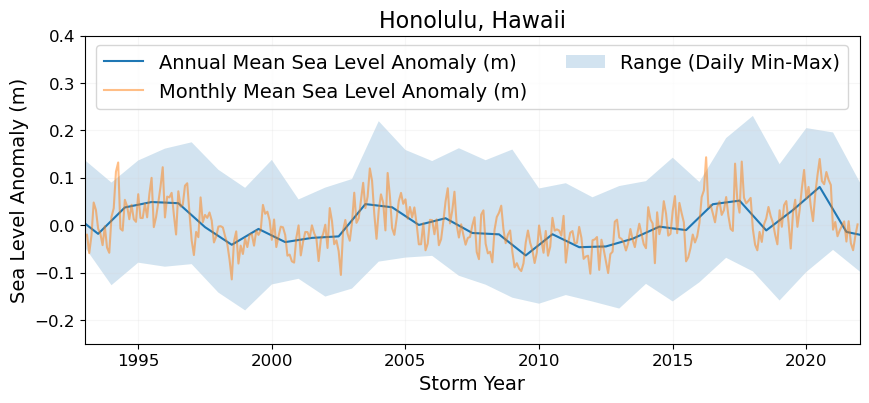

In [88]:

# get record_id of "Honolulu, Hawaii" station
rid = rsl_subset.station_name.str.contains('Honolulu, Hawaii').argmax()
rid

rsl_yearly_mean['rsl_anomaly_detrended'].isel(record_id=rid).plot(x='storm_year',label='Annual Mean Sea Level Anomaly (m)')

# convert rsl_monthly['storm_time'] to float
storm_time_float = rsl_monthly['storm_time.year'] + (rsl_monthly['storm_time.month']-1)/12
plt.plot(storm_time_float, rsl_anomalies['rsl_anomaly_detrended'].isel(record_id=rid), label='Monthly Mean Sea Level Anomaly (m)',alpha=0.5)

# get min and max for each month
rsl_yearly_min = rsl_subset.groupby('storm_time.year').min('storm_time')
rsl_yearly_max = rsl_subset.groupby('storm_time.year').max('storm_time')

#make a fill from max to min for each month
plt.fill_between(rsl_yearly_mean.storm_year+0.5, 
                 rsl_yearly_min['rsl_anomaly_detrended'].isel(record_id=rid), 
                 rsl_yearly_max['rsl_anomaly_detrended'].isel(record_id=rid), 
                 alpha=0.2, label='Range (Daily Min-Max)')


plt.ylabel('Sea Level Anomaly (m)')

plt.xlabel('Storm Year')

# change the title to station name
plt.title(rsl_yearly_mean['station_name'].isel(record_id=rid).values)

# Adjust x-axis limits and add a grid
plt.xlim(1993,2022)
plt.ylim(-0.25, 0.4)
plt.grid(alpha=0.2, color='lightgray')

# Add a legend at the top in 2 columns
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1))

# Save the plot to a file
plt.savefig(output_dir / 'SL_YMA_annual.png', dpi=300, bbox_inches='tight')

fig = plt.gcf()

glue("SL_YMA_annual",fig,display=False)

#add El Nino and La Nina years

# # add ENSO to the plots
# # import oni.csv
# oni = pd.read_csv(data_dir/'oni.csv',header=0)
# # change oni index to Date column
# oni.index = pd.to_datetime(oni['Date'] )

# #adjust the index to be float value of fractional year
# oni.index = oni.index.year + (oni.index.month - 1)/12

# ymin, ymax = plt.ylim()

# # Shading El Niño events
# plt.fill_between(oni.index, ymin,ymax, 
#                 where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')
# # Shading La Niña events
# plt.fill_between(oni.index,  ymin,ymax,
#                 where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')


```{glue:figure} SL_YMA_annual
:name: "SL_YMA_annual"

Yearly mean anomalies at the Honolulu tide gauge, background trend removed. Note that the sea level is plotted in units of m, relative to the epoch mean (1983-2001). The monthly mean anomaly (orange) is calculated with respect to the annual (storm year) cycle.
```

## Absolute Value: satellite (trend removed)

In [64]:
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.25deg_1993_2023.nc')

In [65]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at yearly anomalies.

```{margin}
```{caution}
Come back and check this. Need to remove trend, haven't yet. #TODO
```
```

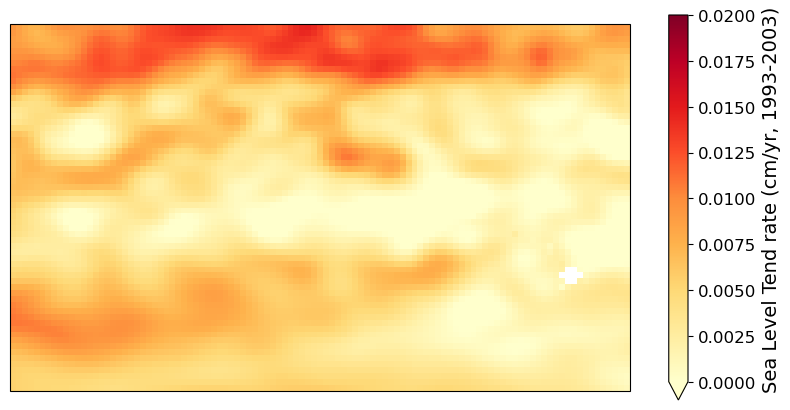

In [101]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013
cmems1993_2003 = cmems.sel(time=slice('1993','2003'))

trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(cmems1993_2003['sla'])

# define vmin and vmax variables
vmin = 0
vmax = 0.02

# make ax,fig
crs = ccrs.PlateCarree()
cmap = 'YlOrRd'
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': crs})
# plot a map of the magnitude of SL change in centimeters
trend_rate.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Sea Level Tend rate (cm/yr, 1993-2003)'}
)


In [67]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013
cmems1993_2003 = cmems.sel(time=slice('1993','2003'))

# get the overall trend (full time series)
trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(cmems['sla'])

#remove the trend from the data
sla_detrended = cmems1993_2003['sla'] - sea_level_trend.sel(time=slice('1993','2003'))

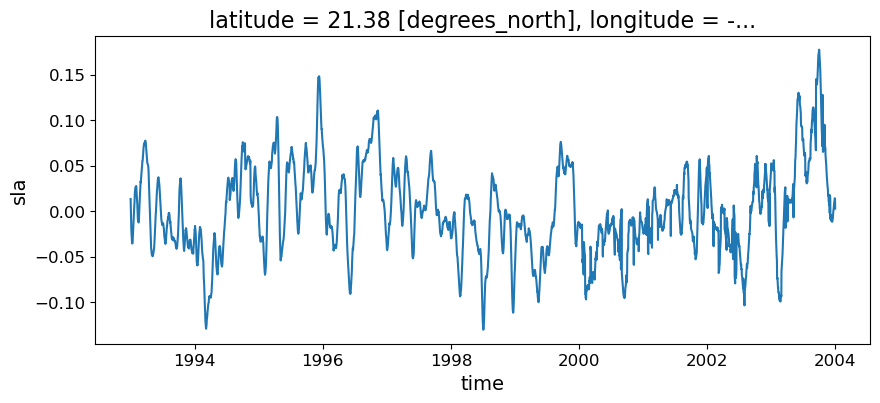

In [68]:
# plot sla_detrended at lat, lon = 21.3, -157.8
sla_detrended.sel(latitude=21.3, longitude=-157.8, method='nearest').plot(label='Sea Level Anomaly (m)')

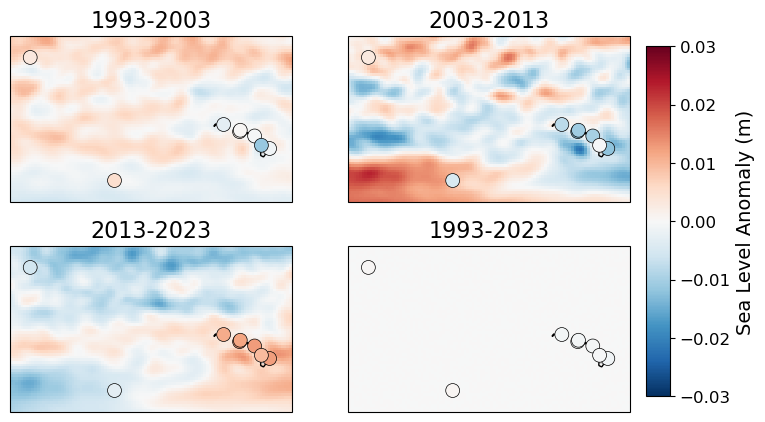

In [100]:
# concentrating on decadal trends
# let's look at 1993-2003 and 2003-2013

trend_mag, sea_level_trend, trend_rate = process_trend_with_nan(cmems['sla'])

#remove the trend from the data
sla_detrended = cmems['sla'] - sea_level_trend

yr_start = [1993,2003,2013,1993]
yr_stop = [2003,2013,2023,2023]

# make 3 subplots for each year range
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(2,2,figsize=(8, 5), subplot_kw={'projection': crs})

# Variable to hold the colorbar handle
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust these values to fit your layout
fig.subplots_adjust(right=0.9)  # Make space for the colorbar
 

vmin = -0.03
vmax = 0.03
# Loop through each period
for i, ax in enumerate(ax.flat):
    # Select the data for the current period and calculate the mean over time
    sla_mean = sla_detrended.sel(time=slice(str(yr_start[i]), str(yr_stop[i]))).mean(dim='time',skipna=True)
    # sla_mean = sla_mean - sea_level_trend.sel(time=slice(str(yr_start[i]), str(yr_stop[i]))).mean(dim='time')

    #subtract the
    
    # Plot the mean sea level anomaly
    c = sla_mean.plot(ax=ax, add_colorbar=False, transform=crs, cmap='RdBu_r')
    
    # Set the title to the current period
    ax.set_title(f'{yr_start[i]}-{yr_stop[i]}')


    # Add coastlines and land  
    palette = sns.color_palette("RdBu_r", as_cmap=True)
    cmap = palette

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    
    # Optionally, adjust color limits for consistency across plots
    c.set_clim(vmin,vmax)

    ax.scatter(rsl_yearly_mean['lon'], rsl_yearly_mean['lat'], transform=crs, s=50,
              c='white', linewidth=0.5, edgecolor='black',zorder=10)
    
    ax.scatter(rsl_yearly_mean['lon'], rsl_yearly_mean['lat'], transform=crs, s=100, 
           c=rsl_monthly.sel(storm_time=slice(str(yr_start[i]),str(yr_stop[i]))).rsl_anomaly_detrended.mean(dim="storm_time"), vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black',zorder=10)

# Add the colorbar
cbar = fig.colorbar(c, cax=cbar_ax)
cbar.set_label('Sea Level Anomaly (m)')


glue("SL_YMA_decadal",fig,display=False)



```{glue:figure} SL_YMA_decadal
:name: "SL_YMA_decadal"

Decadal (or bidecadal, is that a word) mean anomalies of the Hawaiian Islands region, background trend (1993-2023) removed. Note that the sea level is plotted in units of m. The mean anomaly is really small when using the full timeseries, go figure. Stations are plotted as well, showing similar-ish patterns, with some weirdness at Kawaihae that I should attend to.
```

In [93]:
rsl_monthly.sel(storm_time=slice(str(yr_start[i]),str(yr_stop[i]))).rsl_anomaly_detrended.mean(dim="storm_time")

<xarray.DataArray 'rsl_anomaly_detrended' (record_id: 8)>
array([ 0.00031328,  0.00069894, -0.0004884 , -0.0009137 , -0.00053639,
       -0.00100585, -0.00077599, -0.00042888], dtype=float32)
Coordinates:
  * record_id     (record_id) int16 500 520 570 580 590 600 610 5520
    lat           (record_id) float32 28.22 16.75 21.31 ... 19.73 21.43 20.03
    lon           (record_id) float32 182.6 190.5 202.1 ... 204.9 202.2 204.2
    station_name  (record_id) <U17 'Midway' 'Johnston' ... 'Mokuoloe' 'Kawaihae'

```{glue:figure} mma_asl_fig
:name: "mma-asl-fig"
Map of absolute monthly mean sea level anomalies from altimetry for the full record from {glue:text}`station_group`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```


In [94]:
rsl_yearly_mean

<xarray.Dataset>
Dimensions:                (storm_year: 31, record_id: 8)
Coordinates:
  * record_id              (record_id) int16 500 520 570 580 590 600 610 5520
    lat                    (record_id) float32 28.22 16.75 21.31 ... 21.43 20.03
    lon                    (record_id) float32 182.6 190.5 202.1 ... 202.2 204.2
    station_name           (record_id) <U17 'Midway' 'Johnston' ... 'Kawaihae'
  * storm_year             (storm_year) float64 1.992e+03 ... 2.022e+03
Data variables:
    rsl_anomaly            (storm_year, record_id) float32 -0.05539 ... 0.01844
    rsl_mhhw               (storm_year, record_id) float64 -0.209 ... -0.2909
    rsl_anomaly_detrended  (storm_year, record_id) float32 -0.02112 ... -0.1243
Attributes:
    long_name:  Sea Level Anomaly
    units:      m
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...
    epoch:      1993-2001

## Relative Value: tide station (trend removed)
### area-wide map with stations
### station plots: time series  
These should have ONI/ENSO phase included on them

In [8]:
def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  

In [9]:
# remove long-term trend from rsl_yearly
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_yearly.sea_level)

rsl_yearly_detrended = rsl_yearly.sea_level - trend_line_rsl

# add detrended rsl_yearly to rsl_yearly
rsl_yearly['sea_level_detrended'] = rsl_yearly_detrended
rsl_yearly['sea_level_detrended'].attrs = {'long_name': 'sea level anomaly', 'units': 'm'}

In [10]:
# remove annual cycle from rsl_yearly
rsl_yearly_detrended = rsl_yearly_detrended.groupby('time.month') - rsl_yearly_detrended.groupby('time.month').mean(dim='time')

# add to rsl_yearly
rsl_yearly['sea_level_detrended_anom'] = rsl_yearly_detrended
rsl_yearly['sea_level_detrended_anom'].attrs = {'long_name': 'monthly mean sea level anomaly', 'units': 'm'}

## Make a plot